# Threat Model: Secure Containerized Microservices

## 1. Overview
This document outlines the threat modeling exercise performed on the initial insecure application, following STRIDE and MITRE ATT&CK methodologies.

---

## 2. STRIDE Analysis

| Threat Category | Example | Impact | Mitigation |
|----------------|---------|--------|------------|
| Spoofing        | Lack of auth on `/calculate` | Unauthorized access | Add auth/token check |
| Tampering       | Unsafe IP input to `ping` | Command injection | Input validation |
| Repudiation     | No logging | Difficult to audit usage | Implement access logs |
| Information Disclosure | Hardcoded passwords | Credential leak | Use env variables |
| Denial of Service | Unrestricted `ping` or `eval` | Resource exhaustion | Rate limiting |
| Elevation of Privilege | Runs as root | Full system compromise | Use non-root user |

---

## 3. MITRE ATT&CK Mapping (Containers)

| Tactic         | Technique ID | Technique Name | Application Relevance |
|----------------|--------------|----------------|------------------------|
| Initial Access | T1190         | Exploit Public-Facing Application | Command injection in `/ping` |
| Execution      | T1059         | Command and Scripting Interpreter | Use of `eval()` |
| Persistence    | T1525         | Implant Container Image | No image signing or validation |
| Privilege Escalation | T1611  | Escape to Host | Root container user |
| Defense Evasion | T1211        | Exploitation for Defense Evasion | Lack of file system isolation |

---

## 4. Controls Mapping

| Issue | Recommended Control | Framework Reference |
|-------|---------------------|---------------------|
| Hardcoded secrets | Environment secrets | NIST 800-53: SC-12, SC-28 |
| Root container user | Add `USER appuser` | NIST 800-53: AC-6, CM-6 |
| No network restrictions | Isolate with Docker networks | NIST 800-53: SC-7 |
| Missing health check | Add `HEALTHCHECK` | CIS Docker Benchmark |
| Unvalidated inputs | Strict input validation | OWASP Top 10: A1-Injection |

---

## 5. Risk Rating Summary

| Threat | Risk | Likelihood | Impact | Mitigation Priority |
|--------|------|------------|--------|----------------------|
| Command Injection | High | High | Critical | Immediate |
| Credential Exposure | Medium | High | Medium | High |
| Eval-based execution | High | Medium | High | Immediate |
| Root user in container | High | Medium | Critical | Immediate |

---

## 6. Conclusion

This threat model identifies the major flaws in the original application design and container configuration, including insecure defaults, elevated privileges, and code execution risks. By replacing eval, adding input validation, isolating ports, and enforcing least privilege via a non-root Docker user, the security posture of the app is significantly improved. These mitigations support both STRIDE and MITRE frameworks and align with several key NIST 800-53 controls.


## Hardened Architecture Diagram

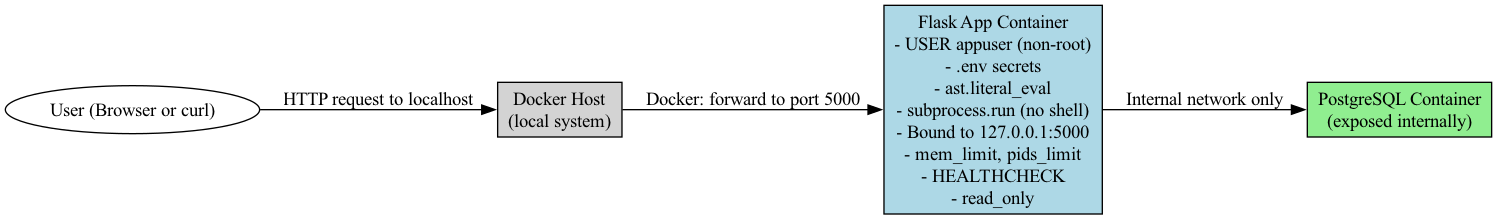

In [11]:
from graphviz import Digraph
from IPython.display import Image

diagram = Digraph(format='png')
diagram.attr(rankdir='LR', fontsize='10')

diagram.node('Client', 'User (Browser or curl)', shape='oval')
diagram.node('Host', 'Docker Host\n(local system)', shape='rectangle', style='filled', fillcolor='lightgrey')
diagram.node('WebContainer', '''Flask App Container
- USER appuser (non-root)
- .env secrets
- ast.literal_eval
- subprocess.run (no shell)
- Bound to 127.0.0.1:5000
- mem_limit, pids_limit
- HEALTHCHECK
- read_only''',
             shape='rectangle', style='filled', fillcolor='lightblue')
diagram.node('DBContainer', 'PostgreSQL Container\n(exposed internally)', shape='rectangle', style='filled', fillcolor='lightgreen')

diagram.edge('Client', 'Host', label='HTTP request to localhost')
diagram.edge('Host', 'WebContainer', label='Docker: forward to port 5000')
diagram.edge('WebContainer', 'DBContainer', label='Internal network only')

diagram_path = 'hardened_architecture_diagram'
diagram.render(diagram_path, cleanup=True)
Image(filename=f'{diagram_path}.png')

In [10]:
"""
Part 5: Auto-Hardening Script
This script:
- Updates daemon.json with secure flags
- Injects USER, HEALTHCHECK, and limits into Dockerfile
- Modifies docker-compose.yml for memory, PID limits, and security
"""

import json
import os
from ruamel.yaml import YAML

# === 1. Harden Docker Daemon ===
daemon_path = '/etc/docker/daemon.json'

def update_daemon_json():
    print("Updating Docker daemon.json ...")
    hardened_config = {
        "icc": False,
        "userns-remap": "default",
        "no-new-privileges": True,
        "log-driver": "json-file",
        "log-opts": {
            "max-size": "10m",
            "max-file": "3"
        }
    }

    try:
        if os.path.exists(daemon_path):
            with open(daemon_path, 'r') as f:
                current = json.load(f)
        else:
            current = {}

        current.update(hardened_config)

        with open(daemon_path, 'w') as f:
            json.dump(current, f, indent=2)

        print("daemon.json updated successfully.")
    except Exception as e:
        print(f"Error updating daemon.json: {e}")

# === 2. Harden Dockerfile ===
def harden_dockerfile(file_path='Dockerfile'):
    print("Hardening Dockerfile ...")
    with open(file_path, 'r') as f:
        lines = f.readlines()

    updated_lines = []
    has_user, has_health = False, False
    for line in lines:
        if 'USER' in line:
            has_user = True
        if 'HEALTHCHECK' in line:
            has_health = True
        updated_lines.append(line)

    if not has_user:
        updated_lines.insert(-1, 'USER appuser\n')

    if not has_health:
        updated_lines.insert(-1, 'HEALTHCHECK CMD curl --fail http://localhost:5000/ || exit 1\n')

    with open(file_path, 'w') as f:
        f.writelines(updated_lines)

    print("Dockerfile hardened.")

# === 3. Harden docker-compose.yml ===
def harden_compose(file_path='docker-compose.yml'):
    print("Hardening docker-compose.yml ...")
    yaml = YAML()
    with open(file_path, 'r') as f:
        data = yaml.load(f)

    service = data['services']['web']
    service['read_only'] = True
    service['security_opt'] = ['no-new-privileges:true']
    service['mem_limit'] = '256m'
    service['pids_limit'] = 100

    with open(file_path, 'w') as f:
        yaml.dump(data, f)

    print("docker-compose.yml hardened.")

# === Run All ===
if __name__ == "__main__":
    update_daemon_json()
    harden_dockerfile()
    harden_compose()

Updating Docker daemon.json ...
Error updating daemon.json: [Errno 2] No such file or directory: '/etc/docker/daemon.json'
Hardening Dockerfile ...


FileNotFoundError: [Errno 2] No such file or directory: 'Dockerfile'

In [7]:
import os
os.getcwd()

'/Users/Danny/seas-8405/week-7/homework7/deliverables'

In [8]:
os.listdir()

['Deliverables.ipynb',
 'hardened_architecture_diagram.png',
 'threat_model.md',
 '.ipynb_checkpoints']

In [9]:
harden_dockerfile('../before/Dockerfile')

Hardening Dockerfile ...
Dockerfile hardened.
